In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

We begin by generating some data. We use only 3 data points. 

Data is generated using a linear model
$$
y = \textbf{w}^T x + \epsilon
$$
where $\epsilon \sim N(0, \sigma_n)$. We augment each data point by appending a 1 and let w_2 represent the offset. 

In [2]:
# Data parameters
sigma_n = 1
x = np.array([-5, 1.5, 5, 1, 4.5, 4.6, 4.7, 4.8, 4.9, 4.95])  # hand pick some points, because we're only using 32
n = len(x)  # num data points
D = 2  # dimension (including offset)
w = [1.5, 0]  # parameter we're trying to estimate

# compute y
X = np.vstack((x, np.ones((1,n)))) # augment x with ones
w = np.array(w).reshape(2, 1)
y = w.T @ X + np.random.normal(size=(n,))*sigma_n
y = y.T

We choose a prior and plot it below. 

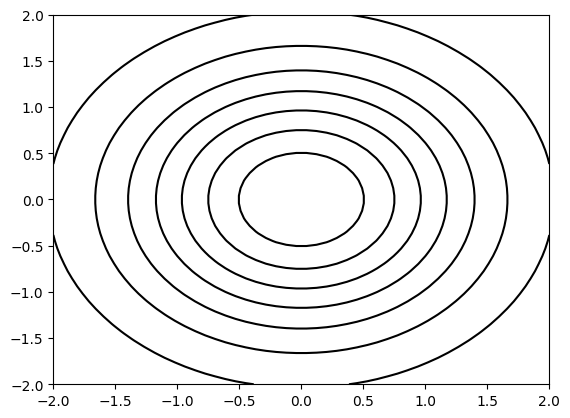

In [3]:
# prior parameters 
mu_p = [0, 0]
Sigma_p = np.eye(2)
prior = multivariate_normal(mu_p, Sigma_p).pdf


xv = np.linspace(-2, 2, 50)
yv = np.linspace(-2, 2, 50)

Xv, Yv = np.meshgrid(xv, yv)
W = torch.tensor([Xv.tolist(), Yv.tolist()]).reshape(2, -1).T.tolist()
Z = []

for w in W:
    Z.append(prior(w))
    
Z = np.array(Z).reshape(50, 50)

plt.contour(Xv, Yv, Z, colors='black');

Now, we construct the likelihood.

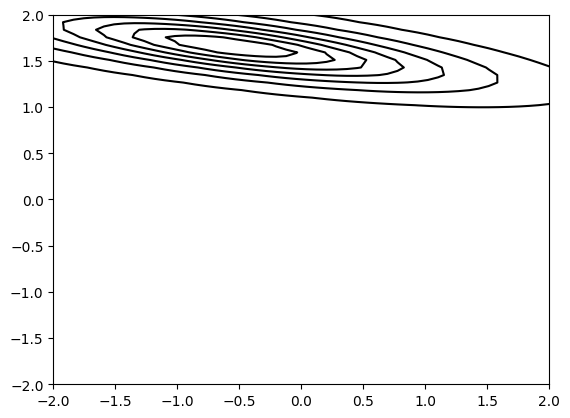

In [4]:
def likelihood(W): 
    out = []
    for w in W.T:
        w.tolist()
        res = (2*np.pi*sigma_n**2)**(D/2)*np.exp(-1/(2*sigma_n**2)*np.linalg.norm(y - X.T @ np.array(w).reshape(2,1)))
        out.append(res.tolist())
    return np.array(out).reshape(50, 50)

W = torch.tensor([Xv.tolist(), Yv.tolist()])
Z = likelihood(W.view(2,-1).numpy())

plt.contour(Xv, Yv, Z.T, colors='black');

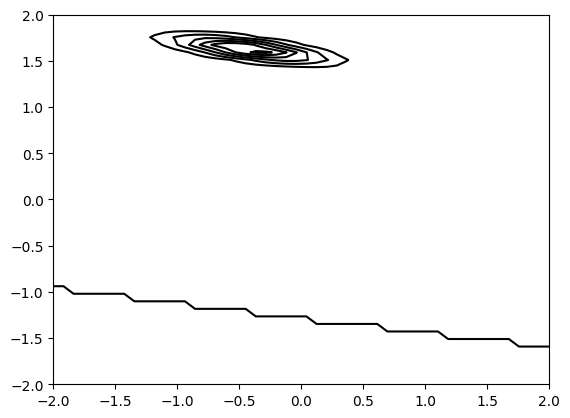

In [5]:
# compute mean and covariance for posterior 
A = sigma_n**-2 * X@X.T + np.linalg.inv(Sigma_p)
A_inv = np.linalg.inv(A)
mu = sigma_n**-2 * A_inv @ X @ y
cov = A_inv

# define posterior
posterior = multivariate_normal(mu.squeeze(), cov).pdf

# plot contours
Z = []
W = torch.tensor([Xv.tolist(), Yv.tolist()]).view(2,-1)
# print(W.T.tolist())
# posterior([-5.0, 5.0])
for w in W.T.tolist():
    Z.append(posterior(w))
Z = np.array(Z).reshape(50,50)
plt.contour(Xv, Yv, Z.T, colors='black');

Plot posterior predictive distribution. The mean is plotted along with one standard deviation from the mean. 

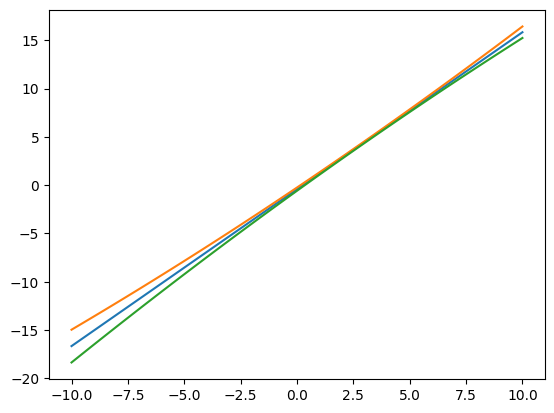

In [8]:
xv = np.linspace(-10, 10, 50)
x_aug = np.hstack((xv.reshape(-1, 1), np.ones_like(xv).reshape(-1,1))).T  # x augmented with 1's for bias
y_mean = 1/sigma_n**2 * x_aug.T @ A_inv @ X @ y
sigma_pred = np.diag(x_aug.T @ A_inv @ x_aug).reshape(-1,1)
plt.plot(xv, y_mean, xv, y_mean + sigma_pred, xv, y_mean - sigma_pred)